In [26]:
import numpy as np
import matplotlib.pyplot as plt

e.g


In [27]:
# Motion Model

def motion_model(x, x_prev, u):
    # Move forward (u= 1)
    if u == 1:
        dx = x - x_prev
        if dx == 1 or dx == -19:
            p = 1
        else:
            p = 0
    
    # Stay still
    elif u == 0:
        if x == x_prev:
            p = 1
        else:
            p = 0
    
    return p

In [28]:
# Measurement Model
def measurement_model(x, likelihood_map):
    return likelihood_map[:, x]

In [29]:
# Likelihood Map

green = np.array([0.2980, 0.6, 0])
blue = np.array([0, 0.2, 0.4])
red = np.array([156, 31, 46]) / 255

# Actyion set: 0: stay still, 1: move forward
u = [1, 1, 1, 1, 1, 1, 1, 0]

# Measurement
z = [1, 0, 0, 0, 0, 1, 0, 0]

# State space: the world has 20 cells, after 20 the robot will be at cell 1 again
X = np.arange(0, 20, 1)

# Belief initialization
bel = np.ones([1, 20]) * 1 / 20  # uniform prior
prior_bel = np.copy(bel)  # use for plot prior belief

# Likelihood map to provide measurements
# The robot receives measurements at cell 4, 9, and 13
likelihood_map = np.ones([1, 20]) * 0.2
for i in [3, 8, 12]:
    likelihood_map[:, i] = 0.8


Text(0, 0.5, 'Action')

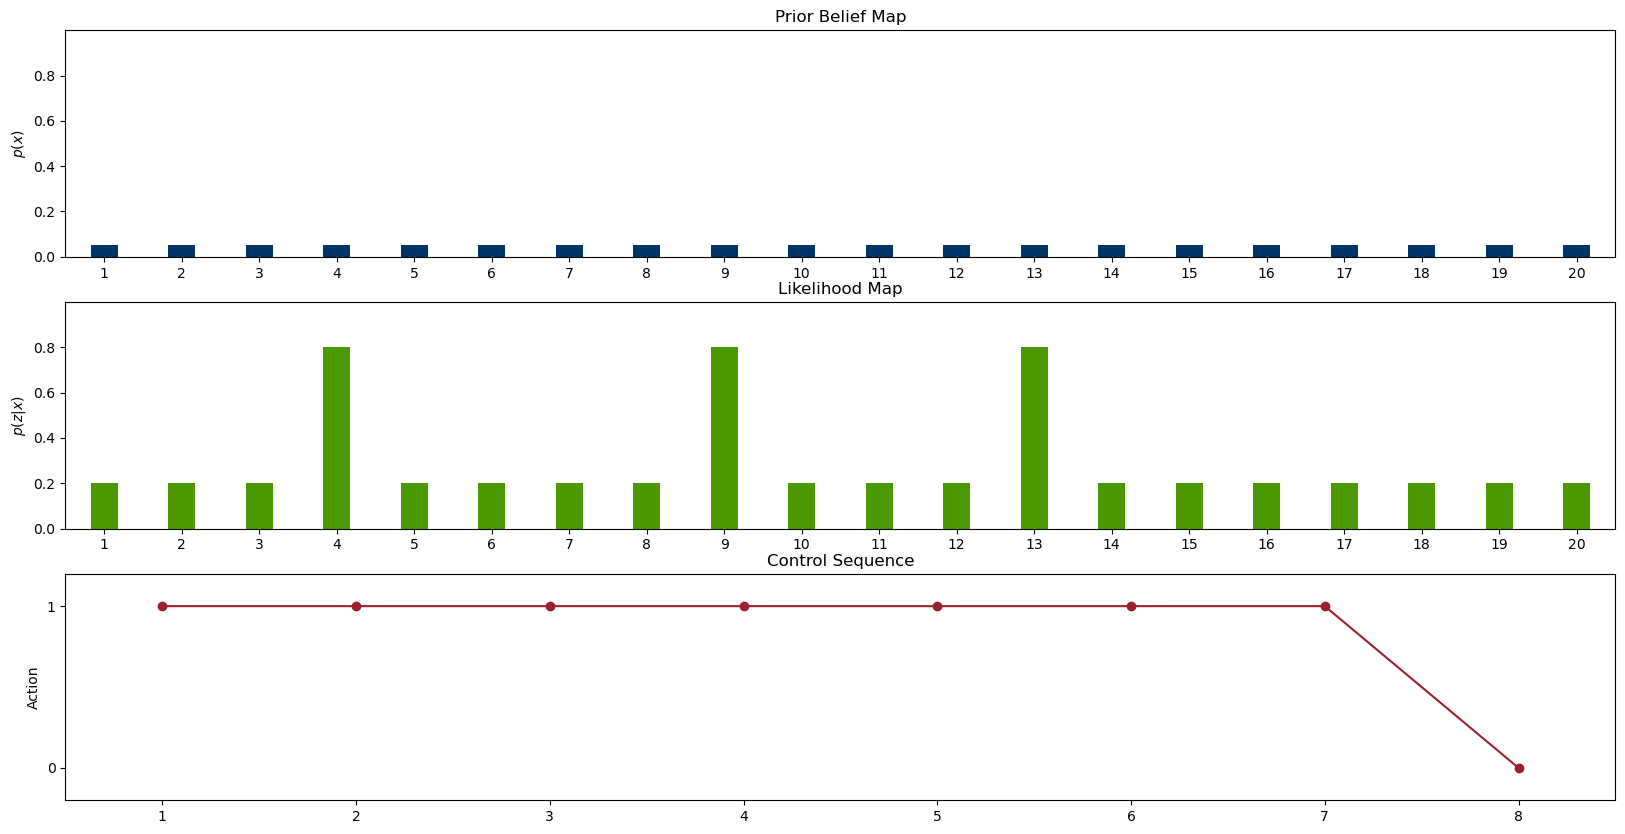

In [30]:
# Plotting the likelihood map
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(10)
  
plt.clf()
# plt.grid(True)
width = 0.35  # set bar width

# plot prior
ax1 = plt.subplot(311)
plt.bar(X+1, prior_bel.reshape(-1), width, color=blue)
plt.title(r'Prior Belief Map')
plt.xticks(X+1)
plt.yticks(np.arange(0, 1, step=0.2))
plt.xlim(0.5, 20.5)
plt.ylim(0, 1)
plt.ylabel(r'$p(x)$')

# plot likelihood
ax2 = plt.subplot(312)
plt.bar(X+1, likelihood_map.reshape(-1), width, color=green)
plt.title(r'Likelihood Map')
plt.xticks(X+1)
plt.yticks(np.arange(0, 1, step=0.2))
plt.xlim(0.5, 20.5)
plt.ylim(0, 1)
plt.ylabel(r'$p(z|x)$')

# plot action sequence
ax3 = plt.subplot(313)
plt.scatter(np.arange(8)+1, np.array(u), color=red)
plt.plot(np.arange(8)+1, np.array(u), color=red)
plt.title(r'Control Sequence')
plt.xticks(np.arange(8)+1, ['1', '2', '3', '4', '5', '6', '7', '8'])
plt.xlim(0.5, 8.5)
plt.yticks([0, 1])
plt.ylim(-0.2, 1.2)
plt.ylabel(r'Action')

<Figure size 640x480 with 0 Axes>

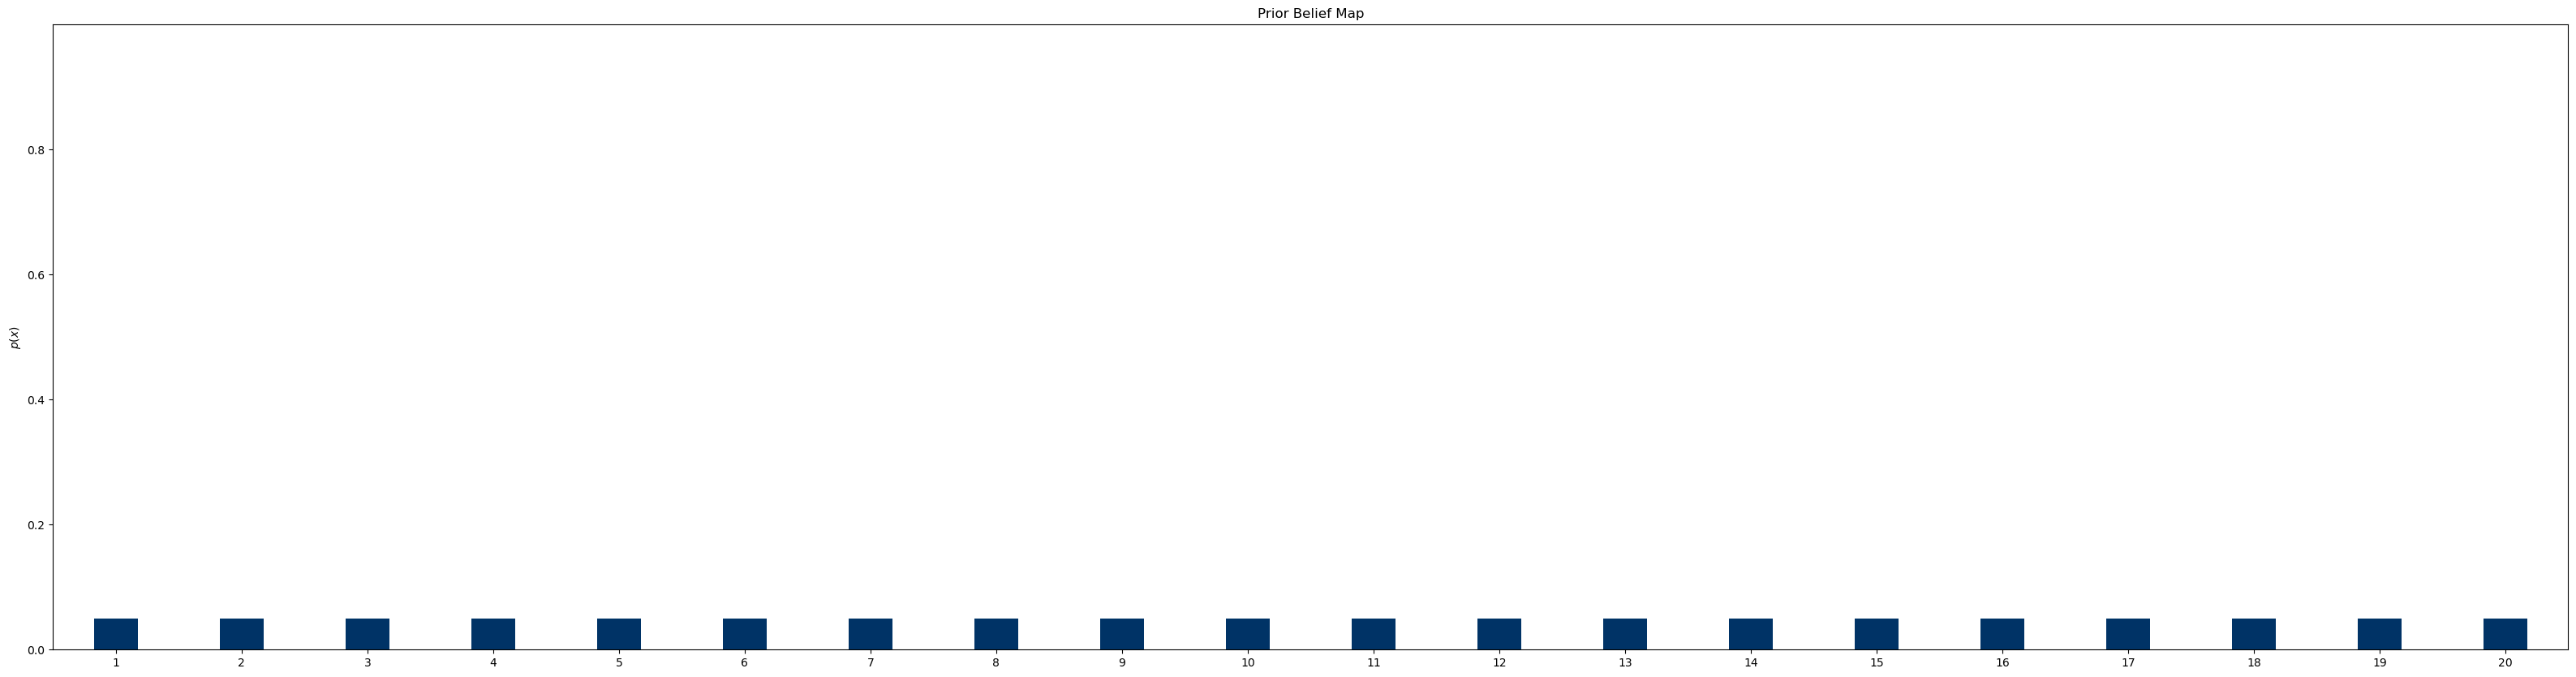

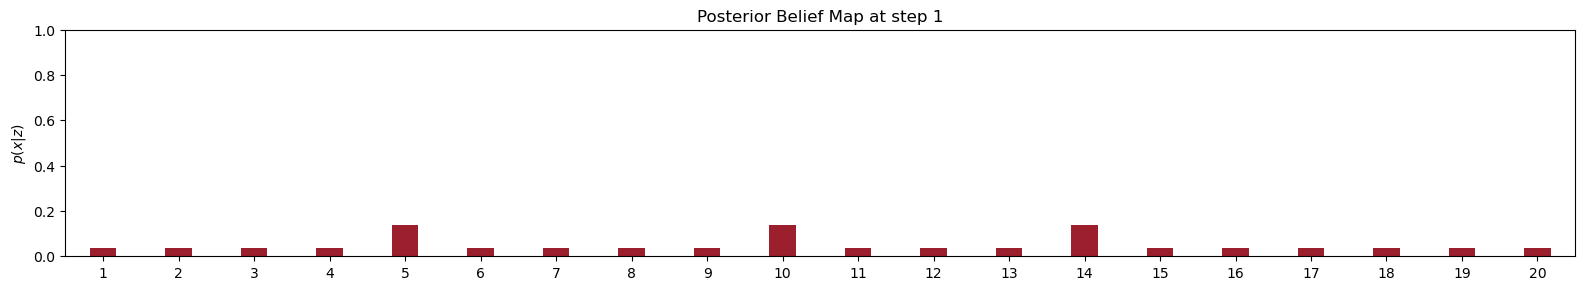

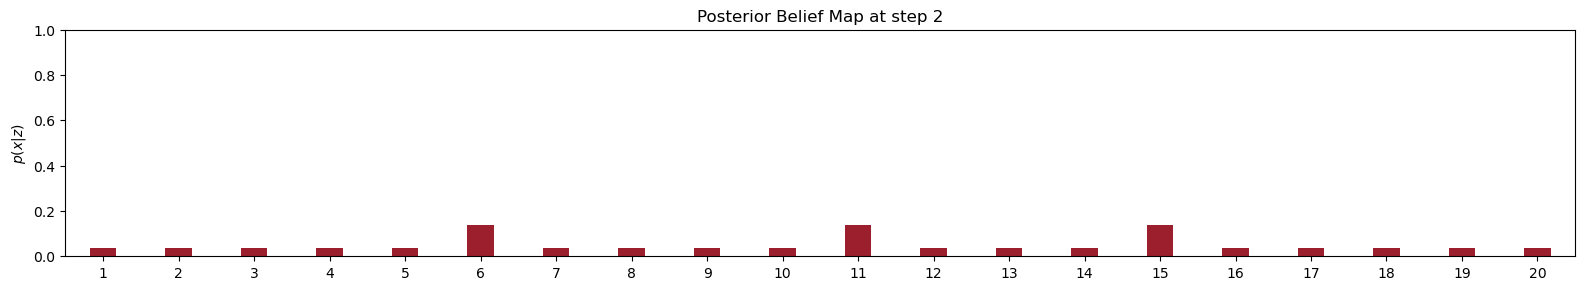

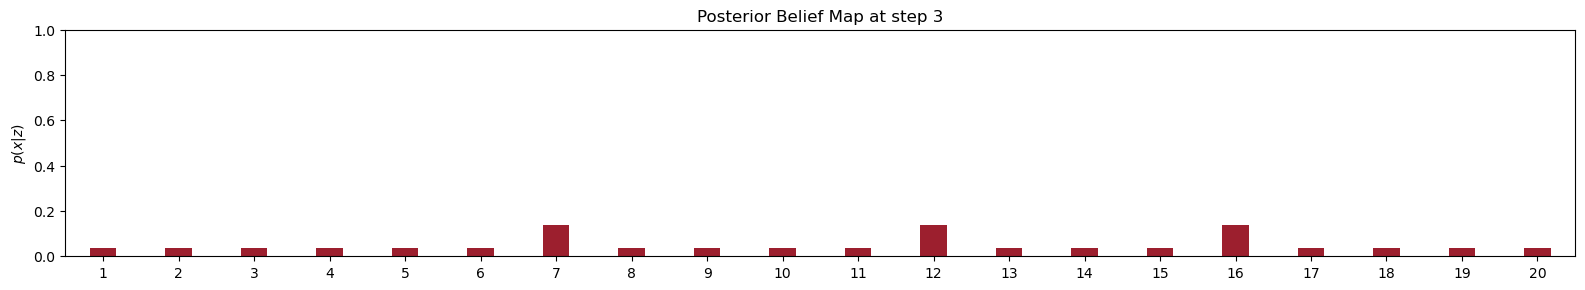

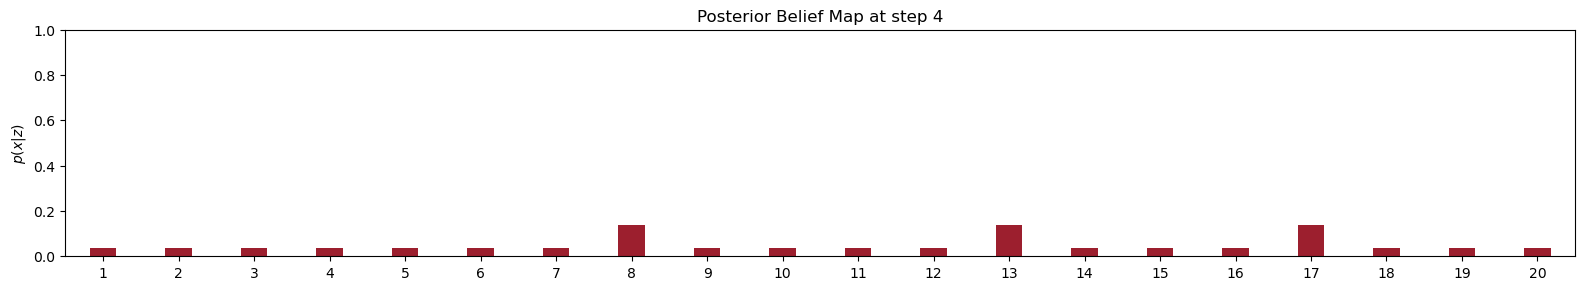

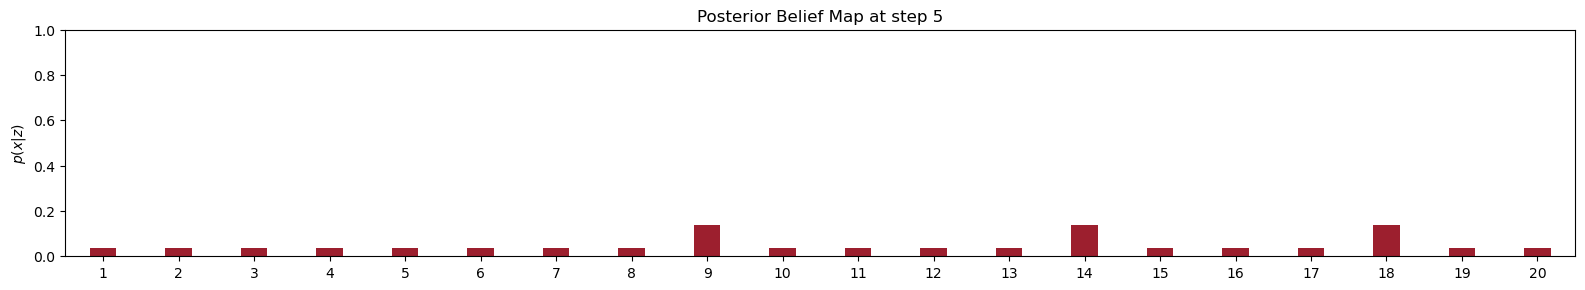

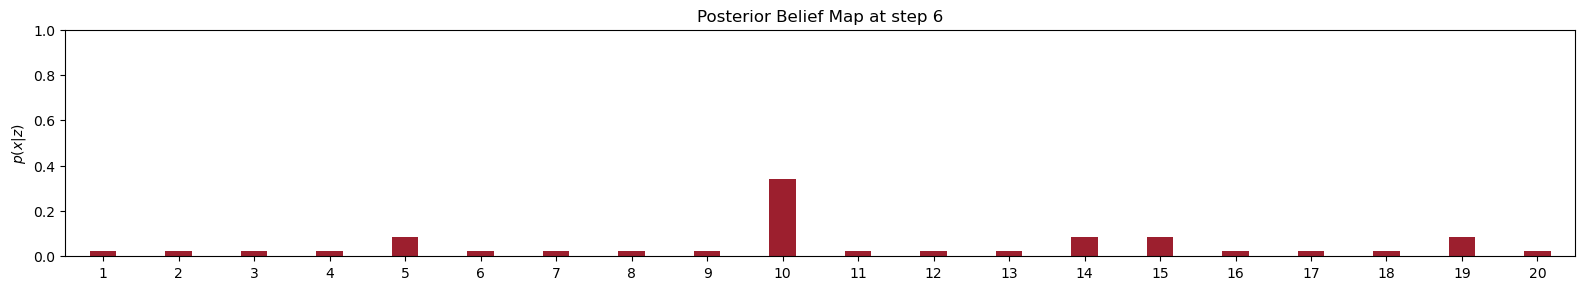

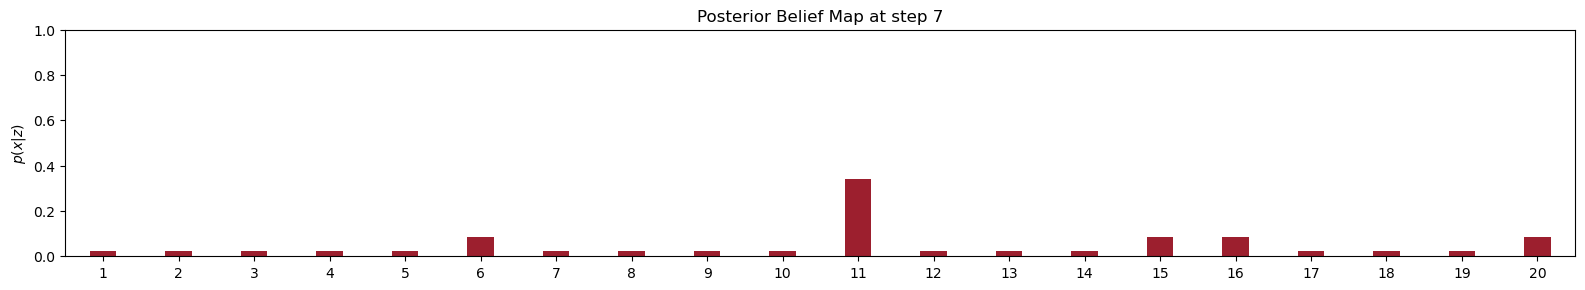

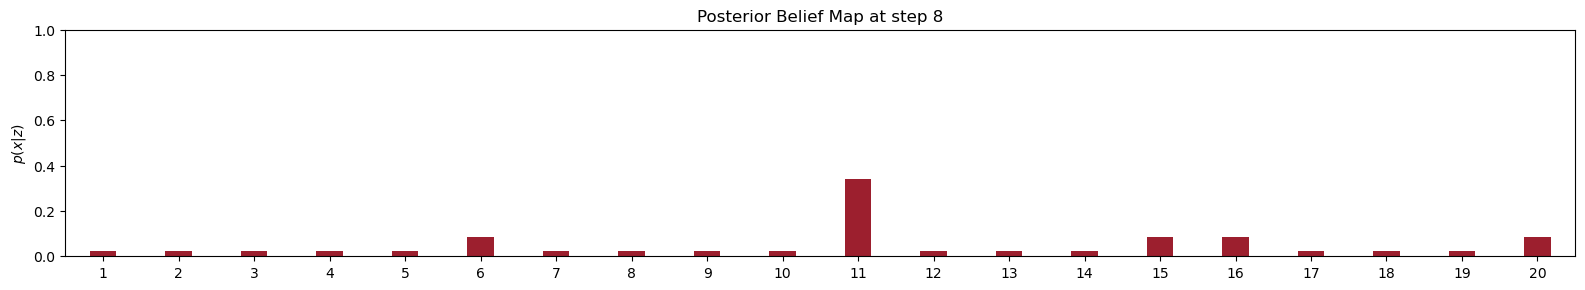

In [31]:
# Markov Localization using Bayes Filter

k = 0
bel_predicted = np.ones([1, 20]) * 1 / 20

fig = plt.figure()

f = plt.figure()
f.set_figwidth(40)
f.set_figheight(10)

plt.clf()
# plt.grid(True)
width = 0.35  # set bar width

# plot prior
plt.bar(X+1, prior_bel.reshape(-1), width, color=blue)
plt.title(r'Prior Belief Map')
plt.xticks(X+1)
plt.yticks(np.arange(0, 1.0, 0.2))
plt.xlim(0.5, 20.5)
plt.ylim(0, 1)
plt.ylabel(r'$p(x)$')

while len(u):
    ############ Update step ############
    if z[k] == 1:  # measurement received
        eta = 0  # normalization constant
        for i in range(len(X)):
            likelihood = measurement_model(X[i], likelihood_map)  # get measurement likelihood
            bel[:, i] = likelihood * bel_predicted[:, i]  # unnormalized Bayes update
            eta = eta + bel[:, i]
        bel = bel / eta  # normalize belief
    
    if z[k] == 0:  # No measurement
        eta = 0  # normalization constant
        for i in range(len(X)):
            bel[:, i] = 0.05 * bel_predicted[:, i]  # unnormalized Bayes update
            eta = eta + bel[:, i]
        bel = bel / eta  # normalize belief

    ############ Prediction step ############
    # prediction; belief convolution
    for m in range(len(X)):
        bel_predicted[:, m] = 0
        for n in range(len(X)):
            pu = motion_model(X[m], X[n], u[0])
            bel_predicted[:, m] = bel_predicted[:, m] + pu * bel[:, n]

    # set the predicted belief as prior
    bel = np.copy(bel_predicted)

    # remove the executed action from the list
    u.remove(u[0])
    k = k + 1
    
    f = plt.figure()
    f.set_figwidth(40)
    f.set_figheight(10)

    # plot posterior belief
    ax3 = plt.subplot(311)
    ax3.set_aspect(3)
    plt.bar(X+1, bel.reshape(-1), width, color=red)
    plt.title(r'Posterior Belief Map at step {0}'.format(8 - len(u)))
    #     plt.title('{0}, {1}, {2}'.format(Name, Test, Date))
    plt.xlim(0.5, 20.5)
    plt.ylim(0, 1)
    plt.ylabel(r'$p(x|z)$')
    plt.xticks(X+1)
    plt.yticks(np.arange(0, 1.2, 0.2))
    if len(u) == 0:
        plt.show()
    else:
        plt.pause(0.5)